In [5]:

import numpy as np
import keras.applications
from keras.applications.resnet50 import preprocess_input as p_i, decode_predictions, ResNet50
from keras.preprocessing import image
import h5py
from keras.activations import softmax, relu, sigmoid
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
import h5py
from PIL import Image, ImageOps
import gdal
import keras.backend as K
from keras.layers import Dense, Input, Conv2D, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Add
from keras.layers.core import Dropout, Activation
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

Using TensorFlow backend.


In [6]:
!export CUDA_VISIBLE_DEVICES=0,1,2
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [7]:
config = tf.ConfigProto(log_device_placement=True,
                                        allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [4]:
def resize(path, size=224):
    ds = gdal.Open(path)
    im = np.nan_to_num(ds.ReadAsArray())
    im = (im * 255 / np.max(im)).astype('uint8')
    img = Image.fromarray(np.stack(im, axis=2))
    ratio = float(size/max(img.size))
    img = img.resize((int(ratio * img.size[0]), int(ratio * img.size[1])))
    return img

In [5]:
def resize_and_pad(path, size=224):
    img = resize(path, size)
    delta_w = size - img.size[0]
    delta_h = size - img.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    img = ImageOps.expand(img, padding)
    return img

In [9]:
def create_model(input_shape, top='flatten', weights='imagenet'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)

    # connects base model with new "head"
    BottleneckLayer = {
        'flatten': Flatten(),
        'avg': GlobalAveragePooling2D(),
        'max': GlobalMaxPooling2D()
    }[top]

    base = ResNet50(input_shape=input_shape,
                             include_top=False, 
                             weights=weights)
    print("here")
    #base.load_weights("imnet.hdf5")
    #print("weights done")
    x = BottleneckLayer(base.output)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=base.inputs, outputs=x)
    return model

In [7]:
#tempmodel = create_model((222, 222, 3))
model = create_model((224, 224, 3))

/home/catherinecang/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


here


In [8]:
tempmodel.layers.pop(0)
inputs = Input(shape=(889, 889, 3)) 
x = Conv2D(3, 5, strides=(4, 4))(inputs) # 2 layers of strides 2 5 3
x = tempmodel(x)

NameError: name 'tempmodel' is not defined

In [34]:
newm = Model(inputs=inputs, outputs=x)
newm.summary() #resnet 34 / 17 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 889, 889, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 3)       228       
_________________________________________________________________
model_3 (Model)              (None, 1)                 23688065  
Total params: 23,688,293
Trainable params: 23,635,173
Non-trainable params: 53,120
_________________________________________________________________


In [137]:
dummy = np.zeros((10, 889, 889, 3))

In [79]:
opt = SGD(lr=1e-5, decay=1e-6)
newm.compile(optimizer=opt, loss='mse')

In [140]:
newm.predict(dummy)

array([[3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09],
       [3.3863918e+09]], dtype=float32)

# New model

In [4]:
from classification_models.resnet import ResNet18, preprocess_input


In [35]:
model = ResNet18((220, 220, 3), classes=1, weights=None)

In [36]:
inp = Input((889, 889, 3))
x = Conv2D(3, 5, strides=(2, 2))(inp)
x = Conv2D(3, 5, strides=(2, 2))(x)
x = model(x)
model2 = Model(inputs=inp, outputs=x)

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 220, 220, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 220, 220, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_55 (ZeroPadding2 (None, 226, 226, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 110, 110, 64) 9408        zero_padding2d_55[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [15]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 889, 889, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 443, 443, 3)       228       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 3)       228       
_________________________________________________________________
resnet18 (Model)             (None, 1)                 11187402  
Total params: 11,187,858
Trainable params: 11,179,916
Non-trainable params: 7,942
_________________________________________________________________


In [23]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name
def residual_conv_block(filters, stage, block, strides=(1, 1), attention=None, cut='pre'):
    def layer(input_tensor):

        # get params and names of layers
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
        else:
            raise ValueError('Cut type not in ["pre", "post"]')

        # continue with convolution layers
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        # use attention block if defined
        if attention is not None:
            x = attention(x)

        # add residual connection
        x = Add()([x, shortcut])
        return x

    return layer


In [24]:
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='conv',
     attention=None):
    
    """
    TODO
    """

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # choose residual block type
    if block_type == 'conv':
        residual_block = residual_conv_block
    elif block_type == 'bottleneck':
        residual_block = residual_bottleneck_block
    else:
        raise ValueError('Block type "{}" not in ["conv", "bottleneck"]'.format(block_type))

    attention_block = None

    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    # resnet bottom
    #x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    #x = Conv2D(3, (5,5), strides=(2, 2), name="myconv1", **conv_params)(x)
    #x = BatchNormalization(name='bn00', **bn_params)(x)
    #x = Conv2D(3, (5,5), strides=(2, 2), name="myconv2", **conv_params)(x)
    x = BatchNormalization(name='bn001', **bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = residual_block(filters, stage, block, strides=(1, 1),
                                   cut='post', attention=attention_block)(x)
                
            elif block == 0:
                x = residual_block(filters, stage, block, strides=(2, 2),
                                   cut='post', attention=attention_block)(x)
                
            else:
                x = residual_block(filters, stage, block, strides=(1, 1),
                                   cut='pre', attention=attention_block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = Flatten(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)
    else:
        BottleneckLayer = {
            'flatten': Flatten(),
            'avg': GlobalAveragePooling2D(),
            'max': GlobalMaxPooling2D()
        }['flatten']
        x = BottleneckLayer(x)
        x = Dense(1, activation='linear')(x)
    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

In [25]:

def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [105]:
model = build_resnet(input_shape=(889, 889, 3), include_top=False)

In [106]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 889, 889, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 889, 889, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
myconv1 (Conv2D)                (None, 443, 443, 3)  225         bn_data[0][0]                    
__________________________________________________________________________________________________
bn00 (BatchNormalization)       (None, 443, 443, 3)  12          myconv1[0][0]                    
__________________________________________________________________________________________________
myconv2 (C

In [107]:
X_889 = np.load("data/X_three_889.npy")
len(X_889)

393

In [108]:
y = np.load("data/y_density.npy")
ylog = np.log(y)

In [116]:
opt = Adam(lr=1e-9)

model.compile(optimizer=opt, loss='mse')

In [117]:
model.fit(X_889, ylog, epochs=5)

Epoch 1/5
393/393 [==============================] - 19s 49ms/step - loss: 1.4405
Epoch 2/5
393/393 [==============================] - 10s 25ms/step - loss: 1.5476
Epoch 3/5
393/393 [==============================] - 10s 24ms/step - loss: 1.3881
Epoch 4/5
393/393 [==============================] - 9s 24ms/step - loss: 1.4162
Epoch 5/5
393/393 [==============================] - 9s 24ms/step - loss: 1.4044


In [118]:
model.predict(X_889[:5])

array([[4.615705 ],
       [5.4012413],
       [2.7747028],
       [4.2702494],
       [5.0512605]], dtype=float32)

In [112]:
ylog[:5]

array([3.99083419, 4.60816569, 4.20618404, 4.29456061, 4.33073334])

# Generating data

In [7]:
path = '/datasets/data/earthengine_inna'

In [8]:
import os

In [12]:
y_dict = {}
with open('data/nuts3density2015.csv', mode='r') as infile:
    reader = csv.reader(infile)
    y_dict = {rows[1]:rows[2] for rows in reader}

In [13]:
def im_to_arr(path):
    ds = gdal.Open(path)
    arr = np.nan_to_num(ds.ReadAsArray())
    return arr

In [14]:
import os
paths = sorted(os.listdir(path))


In [18]:
len(paths2015)

1000

In [17]:
paths2015 = [p for p in paths if p.split("_")[1] == '2015']

In [19]:
from tqdm import tqdm
def generate_data(filepaths, path_name):
    X = []
    for filename in tqdm(filepaths):
        a = resize_and_pad(os.path.join(path_name, filename))
        X.append(np.array(a))
    return X

In [20]:
X = generate_data(paths2015, path)

100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


In [21]:
X_npy = np.array(X)
#np.save("data/X_889.npy", X_npy)

In [22]:
X_three = X_npy[:,:,:,:3]

In [23]:
X_temp = np.load("perm_data/X_1731.npy")

In [24]:
#np.save("data/X_889_three.npy", X_three)
#X_three = np.load("perm_data/X_1731.npy")
X_total = np.vstack((X_temp, X_three))

In [25]:
X_total.shape

(2731, 224, 224, 3)

In [26]:
np.save("perm_data/X_2731.npy", X_total)

In [92]:
#X_224 = np.array(X_224)
#np.save("data/X_224.npy", X_224)

In [ ]:
X_three = [x[:,:,:3] for x in X_npy]
X_three = np.array(X_three)
X_three.shape

In [46]:
y = np.array([y_dict[x[:5]] for x in paths2015]).astype(float)
y[:10]

array([ 54.3, 101.4,  67.2,  73.7,  76.6, 124.7,  48. ,  51.8, 119.7,
       230.1])

In [47]:
y_curr = np.load("perm_data/y_1731.npy")

In [48]:
len(y_curr)

1731

In [51]:
len(y_total)

2731

In [50]:
y_total=np.hstack((y_curr, y))

In [52]:
np.save("perm_data/y_2731.npy", y_total)

In [46]:
im = X_total[900]

In [49]:
np.all(im == X_three[900-len(X_temp)])

True

In [52]:
ds = gdal.Open(path + "/" + paths[169])

In [53]:
a = ds.ReadAsArray()

In [57]:
a =np.nan_to_num(a)

In [66]:
a = resize_and_pad(path + "/" + paths[169])

In [116]:
X = np.load("perm_data/X_1731.npy")
y = np.load("perm_data/y_1731.npy")

In [118]:
y[800]


247.9

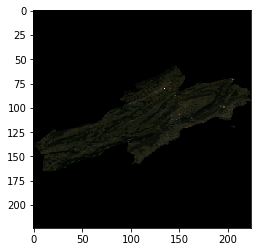

In [121]:
plt.imshow(X[800])

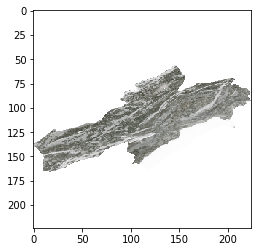

In [123]:
plt.imshow(resize_and_pad(path + "/" + paths[69]))

In [124]:
paths[69]

'CH024_2015_infra.tif'

# Load data + Train

In [151]:
m = create_model((224, 224, 3))
m.summary()

KeyboardInterrupt: 

In [13]:
import numpy as np
X = np.load("perm_data/X_2731.npy")

In [14]:
y_npy = np.load("perm_data/y_2731.npy")

In [15]:
ylog = np.log(y_npy)

In [11]:
ylog_norm = ylog - np.mean(ylog)

In [80]:
#model = create_model((224, 224, 3), weights=None)
from classification_models.resnet import ResNet18, preprocess_input


In [152]:
model = build_resnet(input_shape=(224, 224, 3), include_top=False)

In [153]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn001 (BatchNormalization)      (None, 224, 224, 3)  12          data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_181 (ZeroPadding (None, 230, 230, 3)  0           bn001[0][0]                      
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_181[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

In [16]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, ylog)

In [329]:
opt = Adam(lr=1e-9)
model.compile(optimizer=opt, loss='mse')


In [203]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
2048/2048 [==============================] - 8s 4ms/step - loss: 1.3789
Epoch 2/5
2048/2048 [==============================] - 8s 4ms/step - loss: 1.4288
Epoch 3/5
2048/2048 [==============================] - 8s 4ms/step - loss: 1.3617
Epoch 4/5
2048/2048 [==============================] - 8s 4ms/step - loss: 1.3532
Epoch 5/5
2048/2048 [==============================] - 8s 4ms/step - loss: 1.3511


In [204]:
model.evaluate(X_test, y_test)

683/683 [==============================] - 1s 2ms/step


1.4702024194541474

In [205]:
model.predict(X_test[10:15])

array([[6.149944 ],
       [4.4102187],
       [5.522966 ],
       [4.84503  ],
       [4.1272383]], dtype=float32)

In [206]:
y_test[10:15]

array([3.41114771, 4.72650247, 5.71108905, 4.49647077, 5.37805233])

In [207]:
model.save("checkpoint.hdf5")

# Visualize layers

In [76]:
classifier = build_resnet(input_shape=(224, 224, 3), include_top=False)

In [77]:
classifier.load_weights("checkpoint.hdf5")

In [78]:
conv_layers = [l for l in classifier.layers if type(l)==Conv2D]

In [79]:
len(conv_layers)

21

In [99]:
img_to_visualize = X[1]
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

# Specify the layer to want to visualize
#layer_to_visualize(conv_layers[0])


In [100]:
tf.__version__

'1.9.0'

In [122]:
layer_outputs = [layer.output for layer in classifier.layers[:50]][1:]
activation_model = keras.models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X[:1]) 


In [175]:
first_layer_activation = activations[14]
print(first_layer_activation.shape)

(1, 56, 56, 64)


In [168]:
import imageio
def resize_npy(im, size=224):
    img = Image.fromarray(im)
    ratio = float(size/max(img.size))
    img = img.resize((int(ratio * img.size[0]), int(ratio * img.size[1])))
    return img
def resize_and_pad_npy(im, size=224):
    img = resize_npy(im, size)
    delta_w = size - img.size[0]
    delta_h = size - img.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    img = ImageOps.expand(img, padding)
    return img

(224, 224)
(230, 230)
(112, 112)
(112, 112)
(112, 112)
(114, 114)
(56, 56)
(56, 56)
(56, 56)
(58, 58)
(56, 56)
(56, 56)
(56, 56)
(58, 58)
(56, 56)


<Figure size 432x288 with 0 Axes>

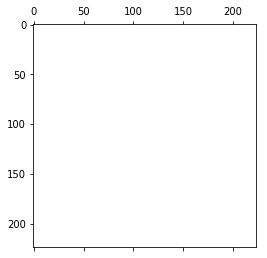

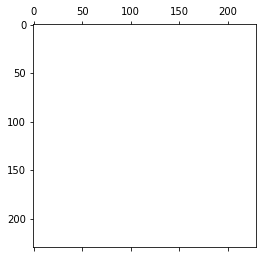

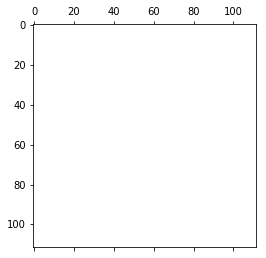

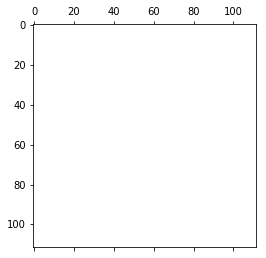

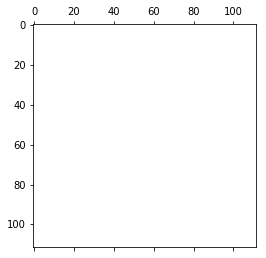

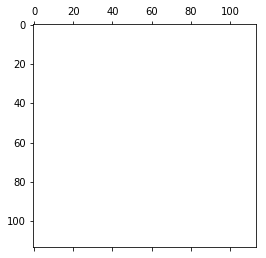

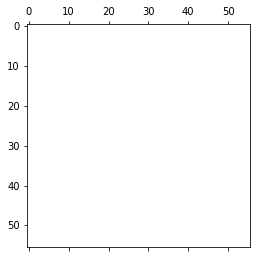

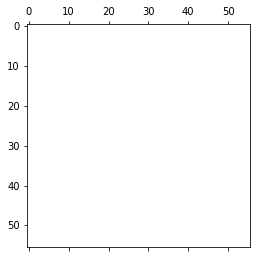

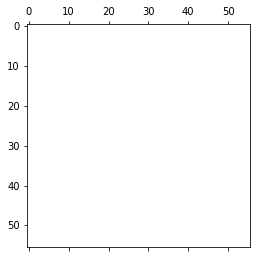

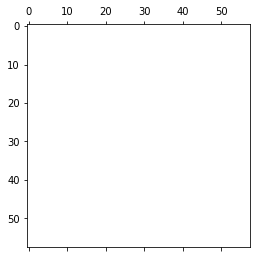

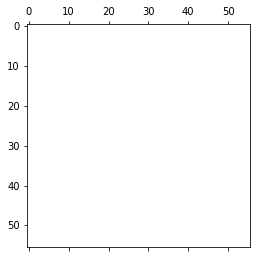

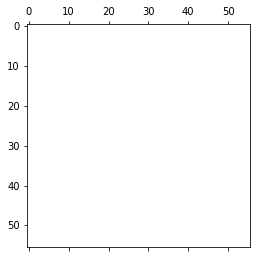

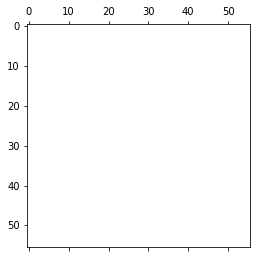

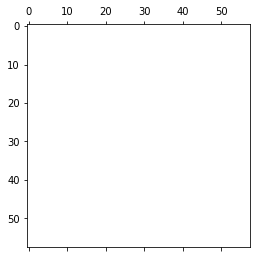

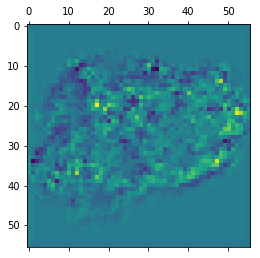

In [178]:
import matplotlib.animation as animation
fig = plt.figure()

ims = []
for i in range(0,15):
    print(activations[i][0,:,:,2].shape)
    im = plt.matshow(activations[i][0,:,:,2], cmap='viridis')
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=700, blit=True,
                                repeat_delay=4000)
ani.save('dynamic_images.mp4')


In [186]:
images = []
images = [resize_npy(a[0,:,:,2]) for a in activations[:15]]
#imageio.mimsave('nice.gif', images)
fig_size
fig_size = plt.rcParams["figure.figsize"]
fig_size

[6.0, 4.0]

<Figure size 1332x756 with 0 Axes>

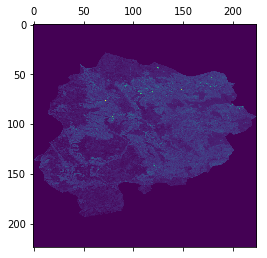

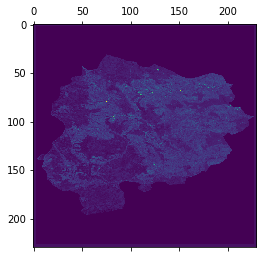

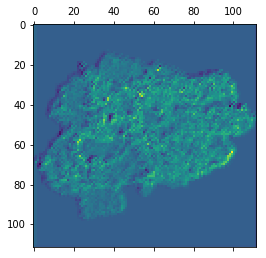

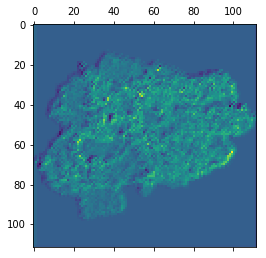

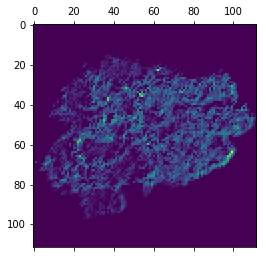

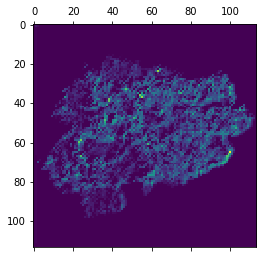

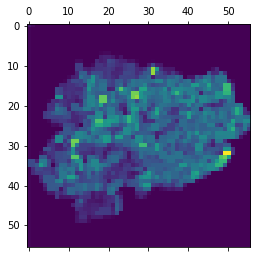

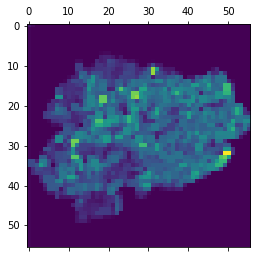

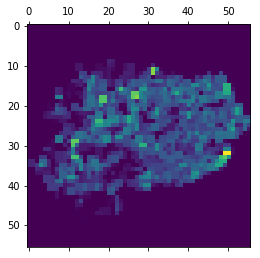

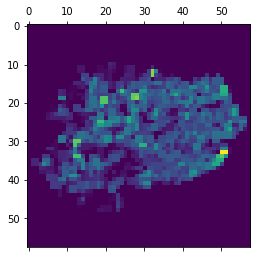

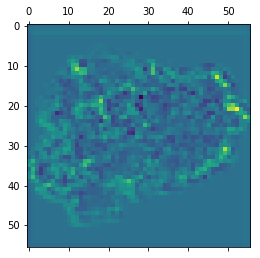

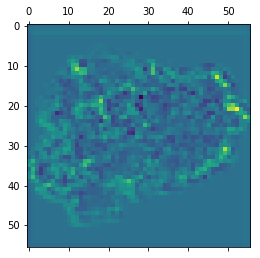

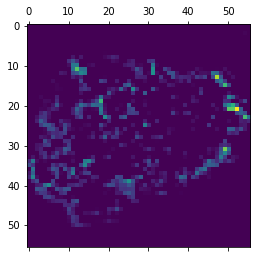

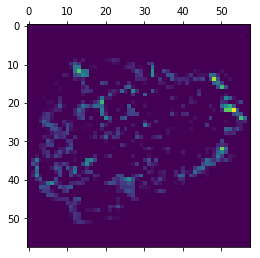

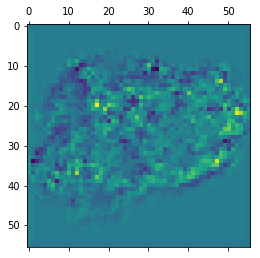

In [187]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)
for i in range(15):
    first_layer_activation = activations[i]
    plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
    plt.savefig("gifs/im" + str(i) + ".jpg")

/home/catherinecang/.local/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)
/home/catherinecang/.local/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/catherinecang/.local/lib/python3.6/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

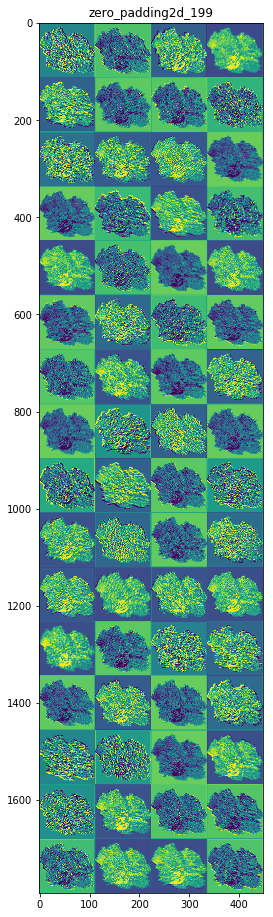

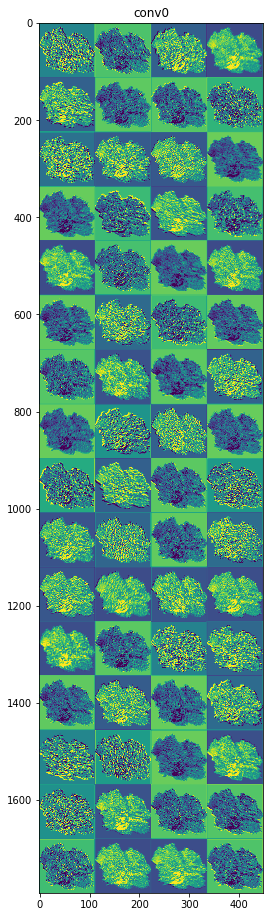

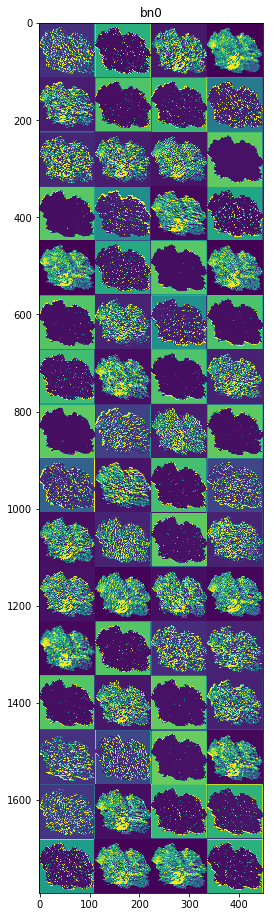

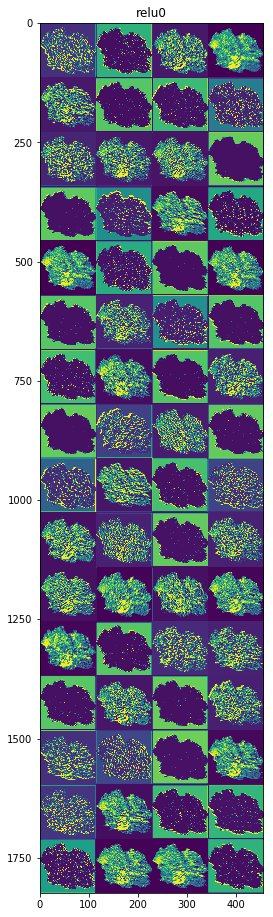

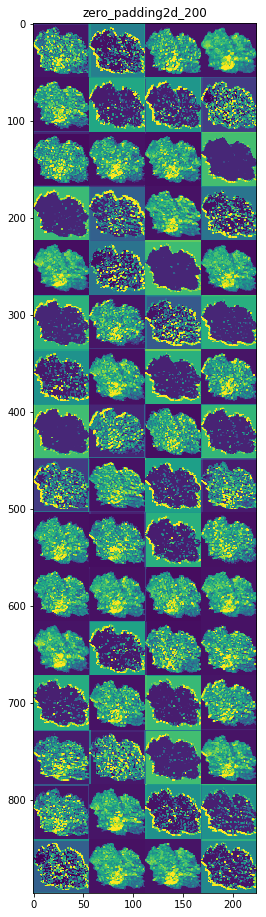

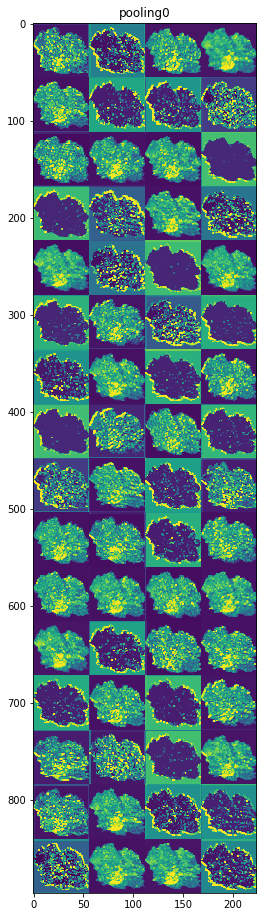

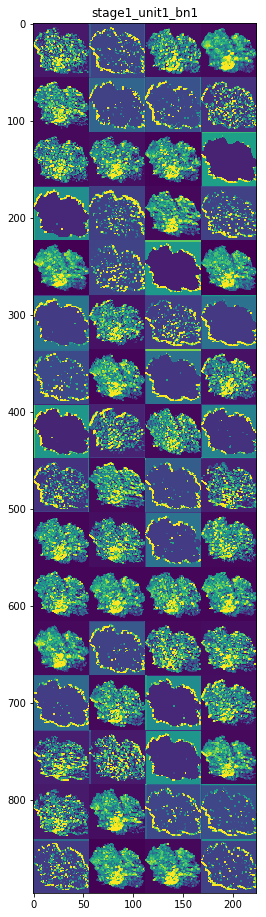

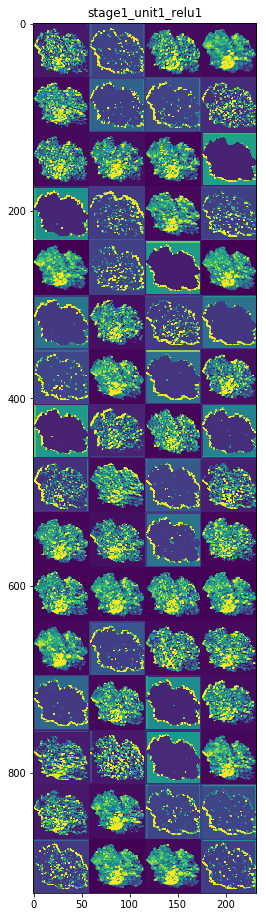

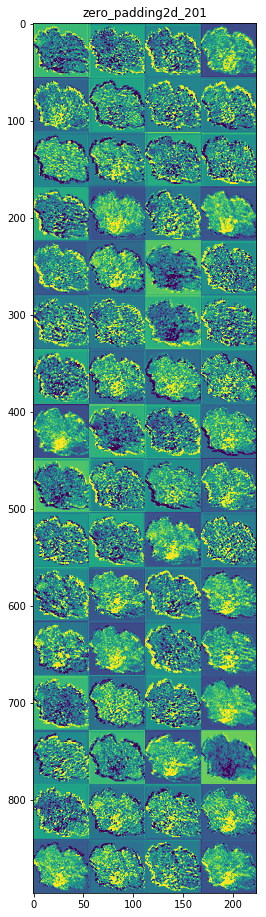

In [222]:
layer_names = []
for layer in classifier.layers[:30]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [36]:
layer_names = []
for layer in classifier.layers[:30]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'classifier' is not defined

# Testing

In [10]:
model2 = create_model((224, 224, 3))

/home/catherinecang/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


here


In [148]:
opt = SGD(lr=1e-7, decay=1e-6)
model2.compile(optimizer=opt, loss='mse')

In [130]:
X_small = X_224[:50]
y_small = ylog[:50]

In [170]:
model2.fit(X_small, y_small, epochs=50)

Epoch 1/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0051
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0050
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0049
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 7/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 8/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 9/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 10/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0046
Epoch 11/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0045
Epoch 12/50
10/10 [==============================] - 0s 11ms/step - loss: 0.0045
Epoch 13/50
10/10 [==================

In [145]:
model.evaluate(X_224[10:], ylog[10:])

383/383 [==============================] - 8s 22ms/step


11.907031087900267

In [171]:
model2.predict(X_224[50:60])

array([[ 1.6926755 ],
       [ 0.02974572],
       [ 0.56700057],
       [-0.22696781],
       [ 0.76184356],
       [ 5.0818806 ],
       [ 0.42683157],
       [ 2.040916  ],
       [ 0.69119257],
       [ 0.23649588]], dtype=float32)

In [172]:
ylog[50:60]

array([5.11439453, 4.80484038, 5.00863329, 5.43633866, 6.6394836 ,
       4.52720864, 4.41763506, 6.40241459, 5.99545657, 4.29182837])

In [173]:
model2.predict(X_224[:10])

array([[4.0773425],
       [4.610155 ],
       [4.3328876],
       [4.1932945],
       [4.185093 ],
       [4.853313 ],
       [3.8174763],
       [3.9140508],
       [4.688249 ],
       [5.346055 ]], dtype=float32)

In [174]:
ylog[:10]

array([3.99083419, 4.60816569, 4.20618404, 4.29456061, 4.33073334,
       4.81543111, 3.8691155 , 3.94352167, 4.77322377, 5.42495002])

# Datagen stuff here

In [42]:
def pp_function(im, scale=10):
    im = im + np.random.normal(loc=0, scale=scale, size=(224, 224, 3))
    im[im > 255] = 255
    im[im < 0] = 0
    return im.astype(int)


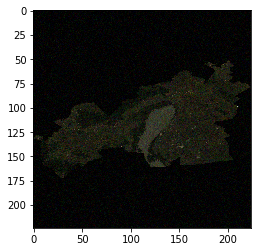

In [37]:
temp = pp_function(X[1])
plt.imshow(pp_function(X[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


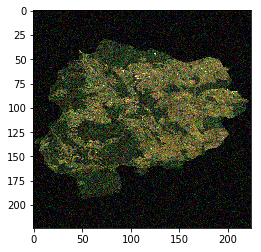

In [50]:
niceX = X[0].copy()
niceX[np.all(niceX == [0, 0, 0], axis=-1)] = 255
plt.imshow(pp_function(X[0], 10) * 3)

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function = pp_function
    )

In [21]:
datagen.fit(X)


In [57]:
#model =build_resnet(input_shape=(224, 224, 3), include_top=False)
opt = Adam(lr=1e-9)

model.compile(optimizer=opt, loss='mse')

In [35]:
np.save("data/test1.npy", X_test[:1])

In [74]:
epochs=20
X_train = X_train.astype(np.float64)
model.fit_generator(datagen.flow(X_train, y_train.astype(np.float64), batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10)

Epoch 1/10
64/64 [==============================] - 37s 579ms/step - loss: 2.0366
Epoch 2/10
64/64 [==============================] - 38s 600ms/step - loss: 1.9580
Epoch 3/10
64/64 [==============================] - 37s 581ms/step - loss: 2.0141
Epoch 4/10
64/64 [==============================] - 38s 601ms/step - loss: 2.0517
Epoch 5/10
64/64 [==============================] - 37s 575ms/step - loss: 2.0591
Epoch 6/10
64/64 [==============================] - 37s 580ms/step - loss: 1.9582
Epoch 7/10
64/64 [==============================] - 37s 584ms/step - loss: 1.9532
Epoch 8/10
64/64 [==============================] - 38s 592ms/step - loss: 2.0102
Epoch 9/10
64/64 [==============================] - 37s 582ms/step - loss: 1.9731
Epoch 10/10
64/64 [==============================] - 37s 581ms/step - loss: 1.9587


In [72]:
model.predict(X_test[10:15])

array([[3.930281 ],
       [4.8227754],
       [4.24696  ],
       [4.7281523],
       [4.5014997]], dtype=float32)

In [73]:
y_test[10:15]

array([3.84801768, 4.06902675, 4.69318106, 5.63764267, 5.50084996])

In [56]:
model.load_weights("checkpoint_datagen.hdf5")

In [340]:
y_train[10:20]

array([5.47100937, 5.00729639, 4.26689633, 3.693867  , 4.89858579,
       4.68951133, 4.62888671, 3.70622809, 4.04305127, 6.16247234])